**PROJETO DE DIAGNÓSTICO INTELIGENTE DE FALHAS EM MÁQUINAS INDUSTRIAIS.**

**Neste projeto, desenvolvemos uma solução completa de manutenção preditiva, com foco em detecção e classificação automática de falhas em máquinas industriais, a partir de dados de sensores operacionais. A abordagem adotada combinou ciência de dados, aprendizado de máquina supervisionado e visualização interativa, permitindo identificar com precisão quando uma falha está prestes a ocorrer e qual seu tipo provável.**

In [1]:
# Importando Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve, classification_report
from IPython.display import display, HTML
!pip install -q dash
!pip install -q dash plotly
import dash
from dash import html, dcc, dash_table
import plotly.express as px
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 11.0 MB/s eta 0:00:00


In [2]:
# Carregando a base de dados
df = pd.read_csv('/content/predictive_maintenance.csv')

In [3]:
# Observando
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
# Observando a quantidade de linhas e colunas
df.shape

(10000, 10)

In [5]:
# Informações sobre os tipos de variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [6]:
# Dados estatísticos
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [7]:
# Verificando a existência de valores nulos
df.isnull().sum()

,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Target,0
Failure Type,0


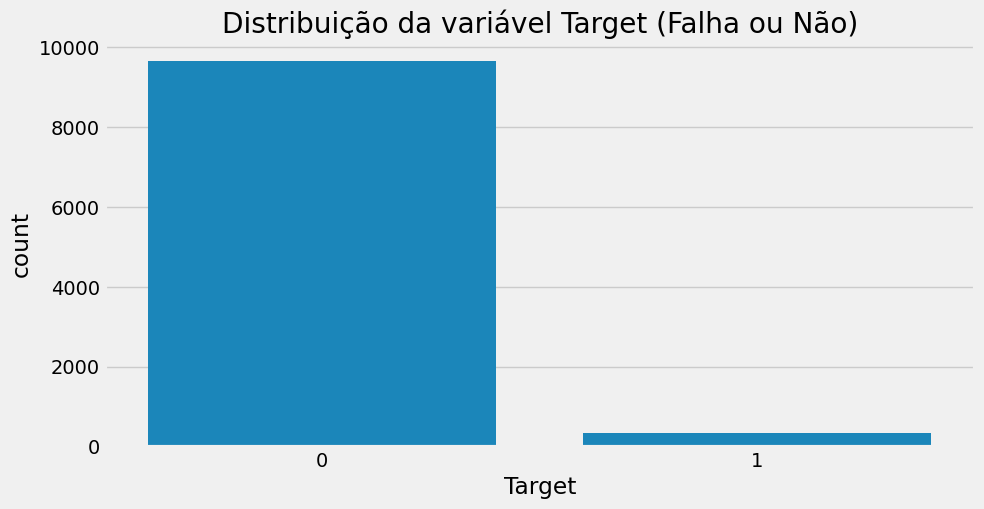

,proportion
Target,
0,0.9661
1,0.0339


In [8]:
# Observado a distribuição da variável binária 'Target'
sns.countplot(data=df, x='Target')
plt.title('Distribuição da variável Target (Falha ou Não)')
plt.show()

df['Target'].value_counts(normalize=True)

**No gráfico acima percebemos a variável alvo 'Target' bem desbalanceada com 96% dos valores sem falha, mais adiante vamos preciar balancear para que o modelo não fique tendencioso.**

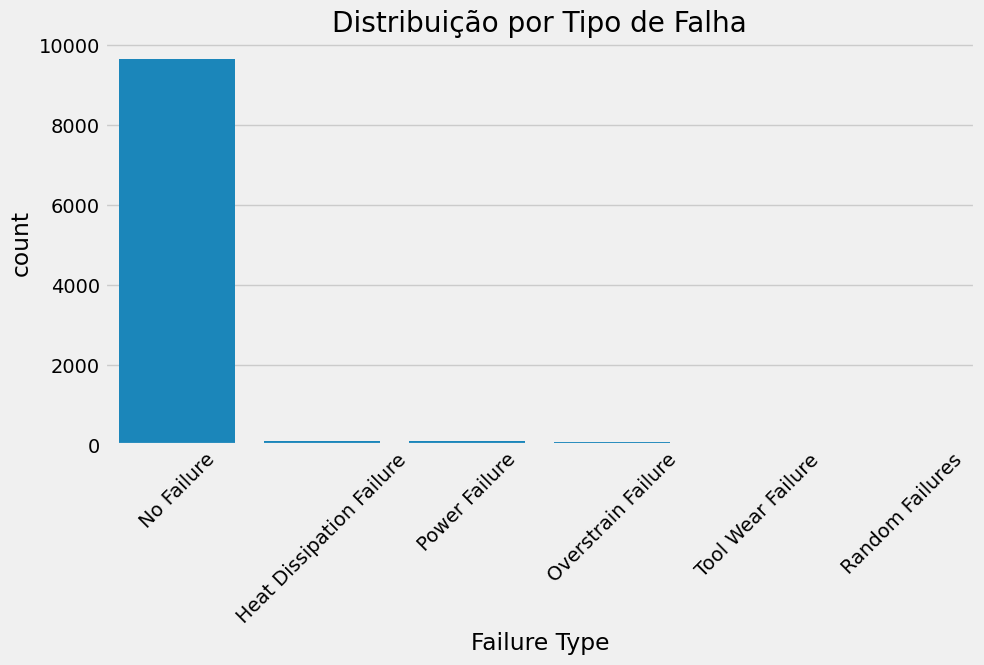

,proportion
Failure Type,
No Failure,0.9652
Heat Dissipation Failure,0.0112
Power Failure,0.0095
Overstrain Failure,0.0078
Tool Wear Failure,0.0045
Random Failures,0.0018


In [9]:
# Observando a variável 'Failure Type'
sns.countplot(data=df, x='Failure Type', order=df['Failure Type'].value_counts().index)
plt.title('Distribuição por Tipo de Falha')
plt.xticks(rotation=45)
plt.show()

df['Failure Type'].value_counts(normalize=True)

**Acima vemos novamente um desbalanceamento muito grande e com classes minoritárias com risco alto de overfitting.**

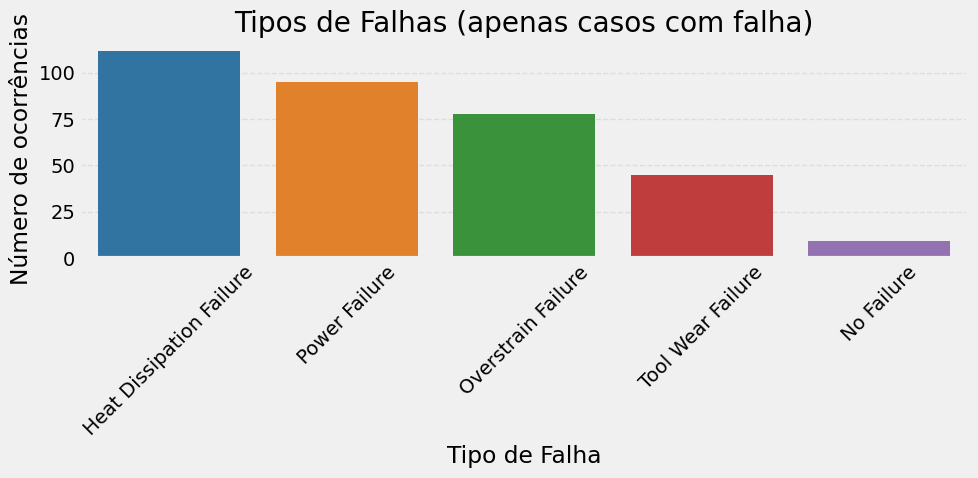

In [10]:
# Filtrar apenas os casos com falha
df_falhas = df[df['Target'] == 1]

# Plotar gráfico de barras com a contagem de falhas por tipo
plt.figure(figsize=(10, 5))
sns.countplot(data=df_falhas, x='Failure Type', order=df_falhas['Failure Type'].value_counts().index, palette='tab10')
plt.title('Tipos de Falhas (apenas casos com falha)')
plt.xlabel('Tipo de Falha')
plt.ylabel('Número de ocorrências')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**O gráfico acima nos mostra os tipos de falhas mais comuns:**

**Heat Dissipation Failure (Falha na dissipação de calor):** A máquina não consegue eliminar o calor gerado, podendo superaquecer componentes.

**Power Failure (Falha de energia):** Problema no fornecimento ou no controle da energia elétrica para o motor/sistema.

**Overstrain Failure (Falha por sobrecarga):** Excesso de esforço mecânico, como torque ou vibração além do limite tolerado.

**Tool Wear Failure (Falha por desgaste da ferramenta):** Desgaste excessivo da ferramenta de corte ou atuação, afetando o desempenho.

**No Failure (Sem falha):** Estado normal de funcionamento, não deveria constar neste gráfico.

In [11]:
# Checar inconsistência entre Target e Failure Type
df[df['Target'] == 1]['Failure Type'].value_counts()

,count
Failure Type,
Heat Dissipation Failure,112
Power Failure,95
Overstrain Failure,78
Tool Wear Failure,45
No Failure,9


**Verificando acima notamos que existem 9 linhas com o No Failure, portanto vamos excluir este erro do dataset.**

In [12]:
# Remover registros inconsistentes (Target == 1 e Failure Type == 'No Failure')
df = df[~((df['Target'] == 1) & (df['Failure Type'] == 'No Failure'))].copy()

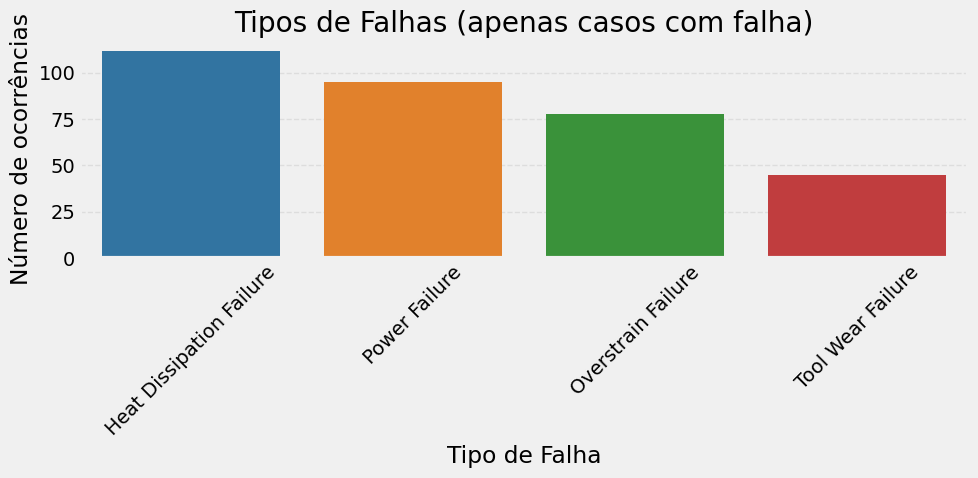

In [13]:
# Filtrar apenas os casos com falha
df_falhas = df[df['Target'] == 1]

# Plotar gráfico de barras com a contagem de falhas por tipo
plt.figure(figsize=(10, 5))
sns.countplot(data=df_falhas, x='Failure Type', order=df_falhas['Failure Type'].value_counts().index, palette='tab10')
plt.title('Tipos de Falhas (apenas casos com falha)')
plt.xlabel('Tipo de Falha')
plt.ylabel('Número de ocorrências')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Agora sim, observamos corretamente os tipos de falhas sendo Heat Dissipation Failure, Power Failure e Overstrain Failure são de extrema importância para o modelo. Percebemos também que a classe 'Random Failures' não aparece por conter um numero muito baixo de ocorrências.**

In [14]:
df[df['Failure Type'] == 'Random Failures'].shape[0]

18

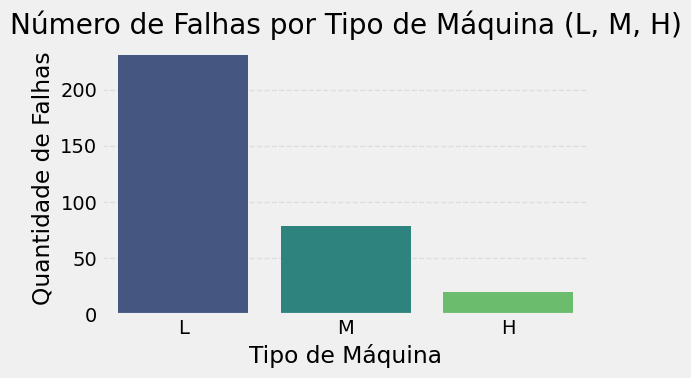

In [15]:
# Filtrar apenas registros com falha
df_falha = df[df['Target'] == 1]

# Contagem de falhas por tipo de máquina
plt.figure(figsize=(6, 4))
sns.countplot(data=df_falha, x='Type', order=['L', 'M', 'H'], palette='viridis')
plt.title('Número de Falhas por Tipo de Máquina (L, M, H)')
plt.xlabel('Tipo de Máquina')
plt.ylabel('Quantidade de Falhas')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Acima percebemos o numero de falhas para cada tipo de máquina, notamos que as máquinas do tipo L (baixa qualidade) concentram a maior parte dos problemas, podem indicar sistemas de proteção mais simples e componentes mais frágeis:**

**L (Low Quality):** mais de 220 falhas, máquina muito vulnerável.

**M (Medium Quality):** Desempenho razoável com cerca de 80 falhas.

**H (High Quality):** Cerca de 20 falhas, alta confiabilidade.

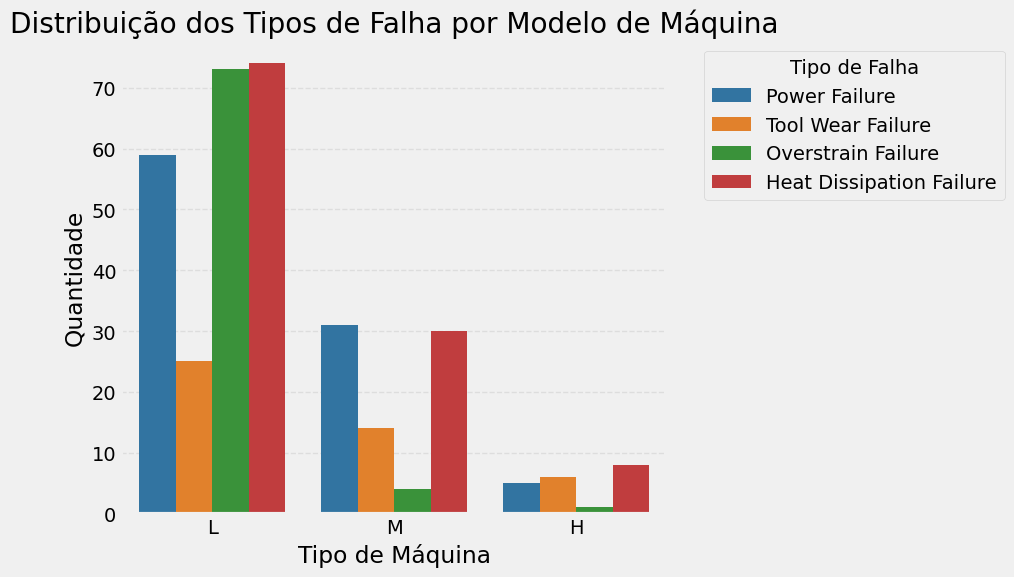

In [16]:
# Tipos de falha por tipo de máquina
plt.figure(figsize=(10, 6))
sns.countplot(data=df_falha, x='Type', hue='Failure Type', palette='tab10', order=['L', 'M', 'H'])
plt.title('Distribuição dos Tipos de Falha por Modelo de Máquina')
plt.xlabel('Tipo de Máquina')
plt.ylabel('Quantidade')
plt.legend(title='Tipo de Falha', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**O que o gráfico acima nos diz:**

**L:** Sofrem muito em quase todos os aspectos como superaquecimento, sobrecarga, falta de energia e até desgaste.

**M**: São bem mais confiáveis, principalmente estruturalmente (baixa sobrecarga).

**H:** Mesmo os melhores modelos não são imunes a falhas térmicas. Poucas falhas em todos os aspectos.

**No geral podemos notar que a falha térmica é a predominante em todas as máquinas, só que em escalas diferente.**

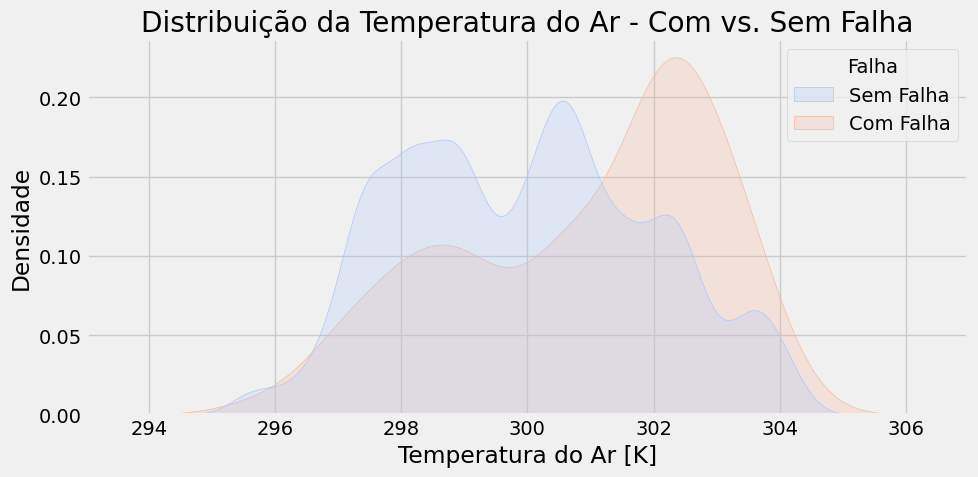

In [17]:
# Traduzir variável de falha para facilitar o gráfico
df['Falha'] = df['Target'].map({0: 'Sem Falha', 1: 'Com Falha'})

# Temperatura do Ar [K]
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='Air temperature [K]', hue='Falha', fill=True, common_norm=False, palette='coolwarm')
plt.title('Distribuição da Temperatura do Ar - Com vs. Sem Falha')
plt.xlabel('Temperatura do Ar [K]')
plt.ylabel('Densidade')
plt.grid(True)
plt.tight_layout()
plt.show()

**Acima percebemos que as falhas costumam acontecer quando a temperatura do ar está mais elevada em torno de 303k.**

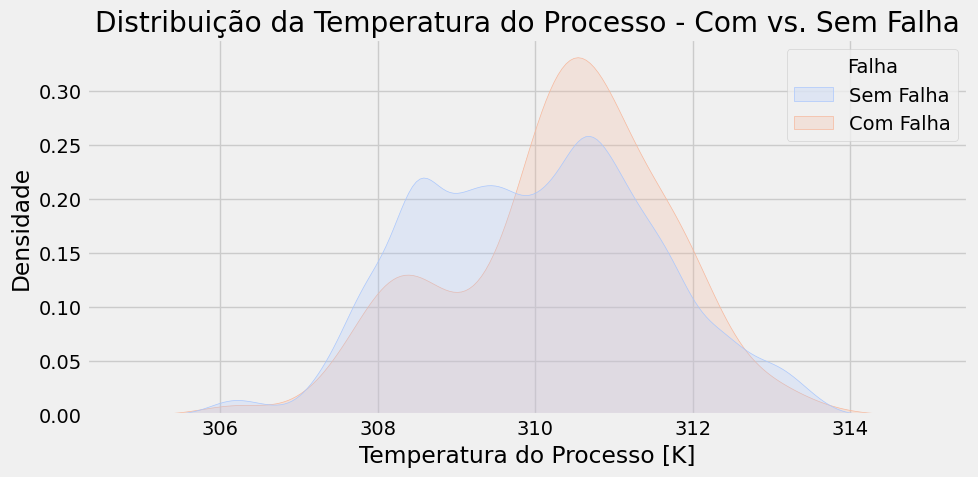

In [18]:
# Temperatura do Processo [K]
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='Process temperature [K]', hue='Falha', fill=True, common_norm=False, palette='coolwarm')
plt.title('Distribuição da Temperatura do Processo - Com vs. Sem Falha')
plt.xlabel('Temperatura do Processo [K]')
plt.ylabel('Densidade')
plt.grid(True)
plt.tight_layout()
plt.show()

**O processo está operando perto do limite térmico seguro, e mesmo pequenas elevações de 1~2 K podem estar desencadeando falhas mecânicas, elétricas ou térmicas (ex: falha de dissipação)**

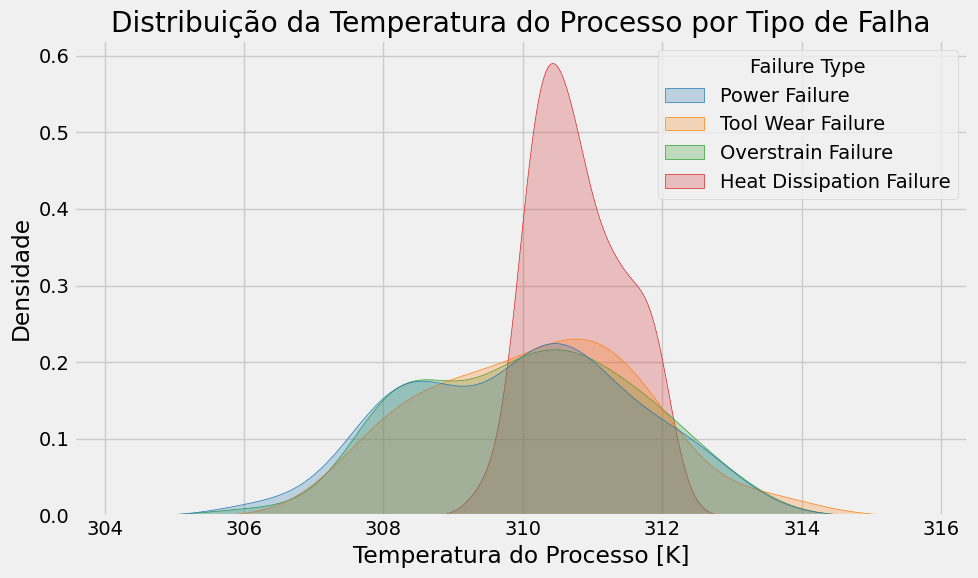

In [19]:
# Gráfico de densidade da Temperatura do Processo por Tipo de Falha
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_falhas,
    x='Process temperature [K]',
    hue='Failure Type',
    fill=True,
    common_norm=False,
    palette='tab10'
)
plt.title('Distribuição da Temperatura do Processo por Tipo de Falha')
plt.xlabel('Temperatura do Processo [K]')
plt.ylabel('Densidade')
plt.grid(True)
plt.tight_layout()
plt.show()


**No gráfico acima só confirmamos o que foi visto antes, uma forte relação da classe 'Heat Dissipation Failure' com temperaturas altas. Essa falha está claramente associada a superaquecimento do processo. Provável problema no sistema de refrigeração ou ventilação interna.**

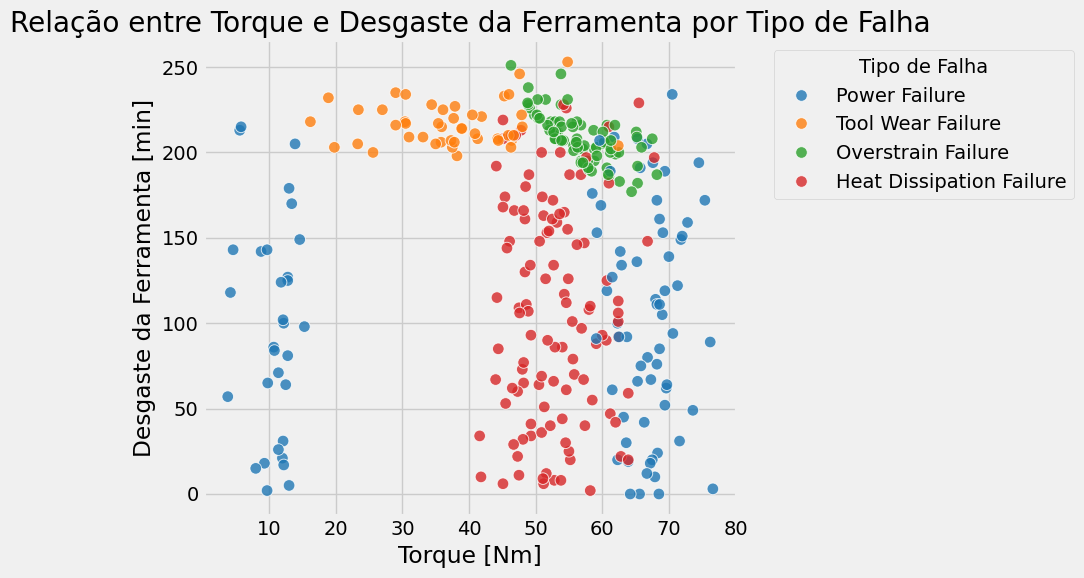

In [20]:
# Filtrar apenas registros com falha
df_falhas = df[df['Target'] == 1].copy()

# Scatter plot: Torque vs Desgaste da ferramenta
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_falhas,
    x='Torque [Nm]',
    y='Tool wear [min]',
    hue='Failure Type',
    palette='tab10',
    alpha=0.8,
    s=70
)
plt.title('Relação entre Torque e Desgaste da Ferramenta por Tipo de Falha')
plt.xlabel('Torque [Nm]')
plt.ylabel('Desgaste da Ferramenta [min]')
plt.grid(True)
plt.legend(title='Tipo de Falha', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**O gráfico acima representa a relação entre o torque aplicado pela máquina (em Nm) e o desgaste da ferramenta (em minutos), classificados por tipo de falha. Essa visualização permite identificar padrões distintos associados a diferentes modos de falha.**

**Power Failure (Falha de Energia):** Os pontos estão espalhados, ocorrendo tanto em torques muito baixos quanto muito altos, com desgaste variado. Isso indica que este tipo de falha não está fortemente associado nem ao torque nem ao tempo de uso, podendo ser causada por falhas elétricas, picos de tensão ou problemas de alimentação.

**Tool Wear Failure (Falha por Desgaste da Ferramenta):** A maioria dos pontos se concentra em desgastes acima de 200 minutos, mesmo com torques moderados. Isso mostra que este tipo de falha está fortemente relacionado ao tempo de uso contínuo da ferramenta, sendo um dos modos de falha mais previsíveis por controle de tempo.

**Overstrain Failure (Falha por Sobrecarga):** Esses pontos se concentram em torques elevados (55 a 65 Nm), geralmente com desgastes também altos. Isso sugere que a sobrecarga ocorre quando a ferramenta já está gasta e a máquina é forçada além de seu limite, causando falha estrutural ou mecânica.

**Heat Dissipation Failure (Falha por Dissipação de Calor):** Essa falha aparece em uma faixa ampla de desgaste, mas sempre com torques médios a altos (~45 a 60 Nm). Isso sugere que o esforço mecânico gera calor, e quando não há dissipação eficiente, a falha ocorre.

**Esse gráfico evidencia que diferentes tipos de falha têm assinaturas distintas em termos de torque e desgaste. Isso pode ser explorado na criação de features combinadas e regras de manutenção preditiva, como alertas para torque elevado em ferramentas muito desgastadas.**

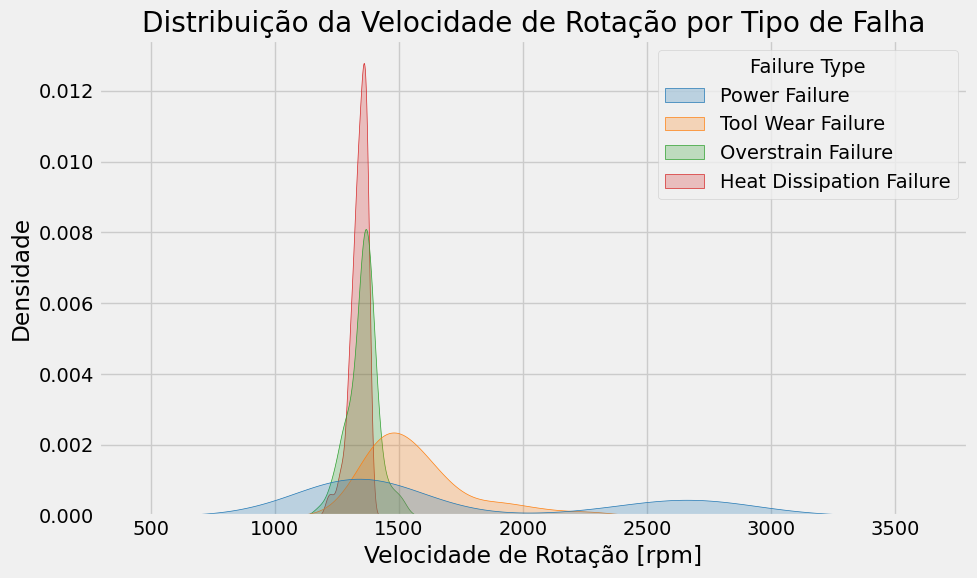

In [21]:
# Filtra apenas registros com falha (Target == 1)
df_falhas = df[df['Target'] == 1].copy()
# Gráfico de distribuição da velocidade de rotação por tipo de falha
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_falhas,
    x='Rotational speed [rpm]',
    hue='Failure Type',
    fill=True,
    common_norm=False,
    palette='tab10'
)
plt.title('Distribuição da Velocidade de Rotação por Tipo de Falha')
plt.xlabel('Velocidade de Rotação [rpm]')
plt.ylabel('Densidade')
plt.grid(True)
plt.tight_layout()
plt.show()


**O que nos informa o gráfico acima:**

**Heat Dissipation Failure:** Um pico bem definido em torno de 1425 rpm, essa falha parece ocorrer com mais frequência em velocidades intermediárias, onde o calor gerado é alto, mas o sistema não dissipa adequadamente.

**Overstrain Failure:** Também concentrada perto de 1425 rpm, indica que sobrecarga mecânica ocorre numa faixa onde o motor entrega alto torque com limitação térmica e desgaste.

**Tool Wear Failure:** Pico ligeiramente acima de 1450 rpm, com distribuição mais ampla até 1700 rpm, isso mostra que o desgaste da ferramenta independe levemente da rotação, mas ocorre mais em velocidades intermediárias.

**Power Failure:** Distribuição bem mais espalhada, indo de 900 até 3100 rpm, é um sinal claro de que falhas de energia não estão associadas diretamente à rotação, podendo vir de falhas externas ao sistema mecânico (ex: falha no inversor ou circuito elétrico).

In [22]:
# Discretizar variáveis contínuas
df_falhas['Faixa_Temp_Proc'] = pd.cut(df_falhas['Process temperature [K]'], bins=[305, 308, 310, 312, 315], labels=['305–308', '309–310', '311–312', '313–315'])
df_falhas['Faixa_Torque'] = pd.cut(df_falhas['Torque [Nm]'], bins=[0, 30, 50, 70, 90], labels=['0–30', '31–50', '51–70', '71–90'])
df_falhas['Faixa_Desgaste'] = pd.cut(df_falhas['Tool wear [min]'], bins=[0, 50, 100, 150, 200, 250], labels=['0–50', '51–100', '101–150', '151–200', '201–250'])

In [23]:
# Criar coluna combinada
df_falhas['Condicao'] = df_falhas['Faixa_Temp_Proc'].astype(str) + ' | ' + \
                        df_falhas['Faixa_Torque'].astype(str) + ' | ' + \
                        df_falhas['Faixa_Desgaste'].astype(str)


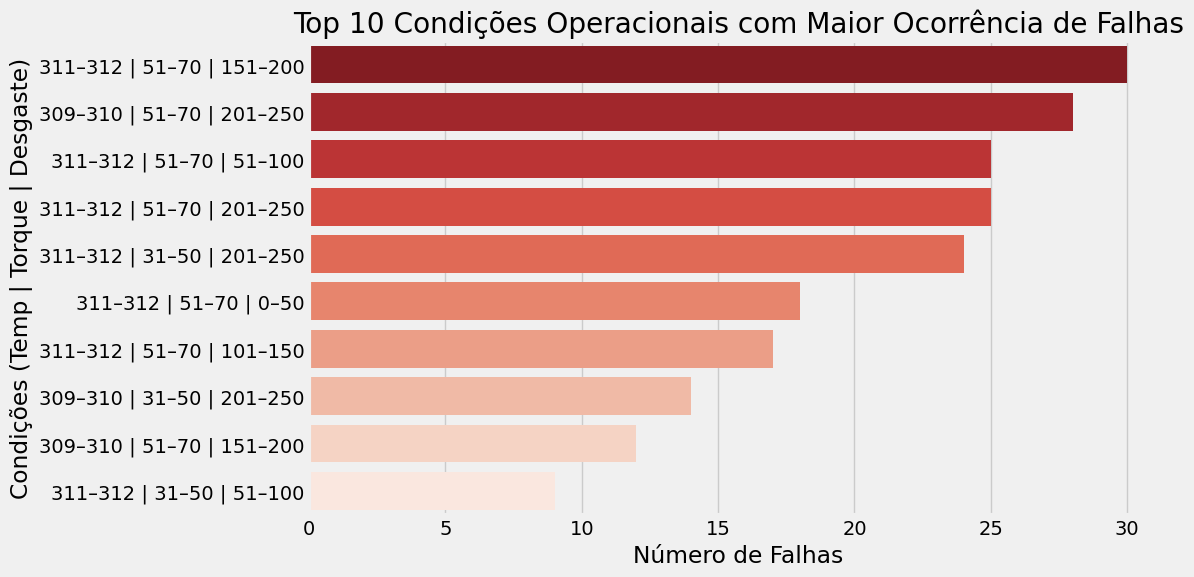

In [24]:
# Contar número de falhas por condição
condicoes = df_falhas['Condicao'].value_counts().head(10)

# Plotar gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x=condicoes.values, y=condicoes.index, palette='Reds_r')
plt.title('Top 10 Condições Operacionais com Maior Ocorrência de Falhas')
plt.xlabel('Número de Falhas')
plt.ylabel('Condições (Temp | Torque | Desgaste)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


**Acima temos uma combinação específica de condições operacionais (Temperatura, Torque e Desgaste de ferramenta) que, quando ocorrem juntas, geram uma quantidade relevante de falhas no sistema.**

**O gráfico evidencia que a maioria das falhas ocorre sob condições combinadas de alta temperatura do processo (acima de 309 K), torque elevado (acima de 50 Nm) e desgaste significativo da ferramenta (acima de 150 min).
A condição mais crítica encontrada foi 311–312 K | 51–70 Nm | 151–200 min, que deve ser considerada como zona de risco para estratégias de manutenção preditiva.**

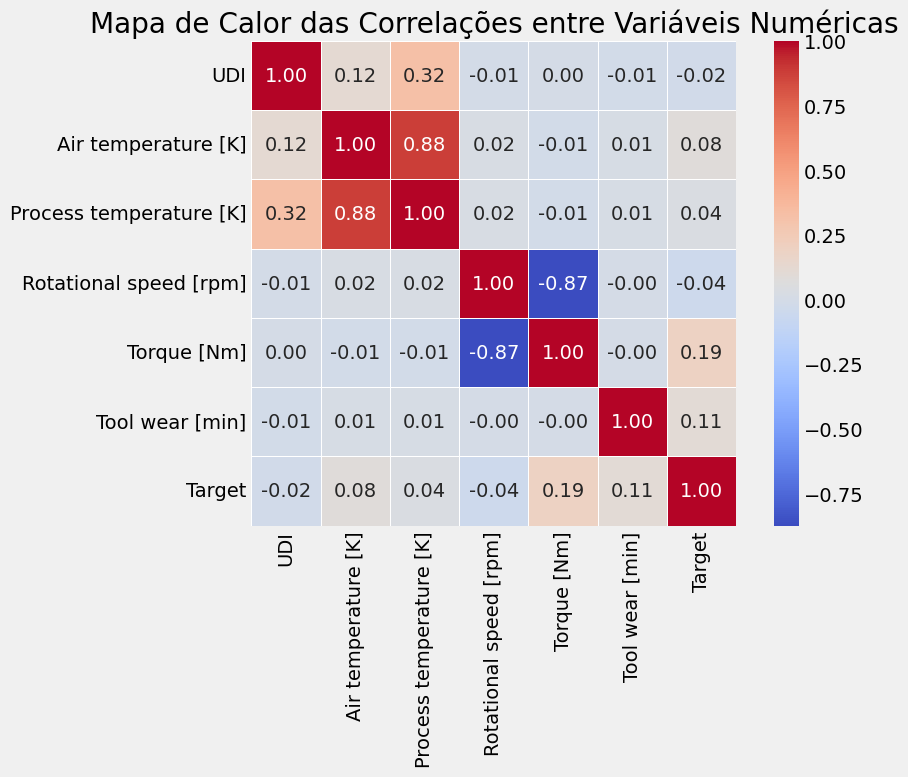

In [25]:
# Seleciona apenas colunas numéricas
df_numericas = df.select_dtypes(include='number')

# Calcula a matriz de correlação
correlacoes = df_numericas.corr()

# Gera o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlacoes, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Mapa de Calor das Correlações entre Variáveis Numéricas')
plt.tight_layout()
plt.show()

**Air temperature [K] e Process temperature [K] possuem correlação muito alta (+0.88) → indicam praticamente a mesma informação.**

**Torque [Nm] e Rotational speed [rpm] têm correlação negativa muito forte (–0.87) → fazem parte de uma relação física esperada (potência constante).**

**A variável Torque [Nm] é a que apresenta maior correlação com o alvo (Target), sugerindo que maior torque pode levar a mais falhas.**

In [26]:
# Criando nova variável com variáveis de alta correlação
df['torque_x_speed'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']
df['temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']

**Essa feature antecipa falhas térmicas como Heat Dissipation Failure, indicando se a máquina está operando com temperatura do processo considerada crítica (acima de 310.5 K). Esse valor foi definido com base nos gráficos que mostraram aumento de falhas térmicas a partir desse ponto.**

In [27]:
df['is_high_process_temp'] = df['Process temperature [K]'] > 310.5


**Cria uma interação entre esforço mecânico (torque) e tempo de uso da ferramenta (desgaste). É uma proxy de acúmulo de esforço.**

In [28]:
df['torque_x_wear'] = df['Torque [Nm]'] * df['Tool wear [min]']

**É uma flag binária indicando se a máquina está em uma condição de esforço mecânico extremo, combinado com ferramenta muito usada.**

In [29]:
df['risco_esforco'] = (df['Torque [Nm]'] > 55) & (df['Tool wear [min]'] > 180)

**Marca se a rotação da máquina está na faixa onde mais ocorreram falhas (baseado no gráfico de rotação × falhas). Ajuda a capturar falhas que ocorrem por vibração excessiva ou limitações operacionais em determinada faixa de RPM**

In [30]:
df['is_critical_rpm'] = df['Rotational speed [rpm]'].between(1400, 1500)

In [31]:
# Excluindo as colunas que não iremos utilizar para a modelagem
df.drop(columns=['UDI', 'Product ID', 'Air temperature [K]', 'Rotational speed [rpm]', 'Falha'], inplace=True)

In [32]:
df.head()

,Type,Process temperature [K],Torque [Nm],Tool wear [min],Target,Failure Type,torque_x_speed,temp_diff,is_high_process_temp,torque_x_wear,risco_esforco,is_critical_rpm
0,M,308.6,42.8,0,0,No Failure,66382.8,10.5,False,0.0,False,False
1,L,308.7,46.3,3,0,No Failure,65190.4,10.5,False,138.9,False,True
2,L,308.5,49.4,5,0,No Failure,74001.2,10.4,False,247.0,False,True
3,L,308.6,39.5,7,0,No Failure,56603.5,10.4,False,276.5,False,True
4,L,308.7,40.0,9,0,No Failure,56320.0,10.5,False,360.0,False,True


In [33]:
# Separando as variáveis numéricas para observar outliers
variaveis = [
    'Process temperature [K]',
    'Torque [Nm]',
    'Tool wear [min]',
    'temp_diff',
    'torque_x_wear'
]

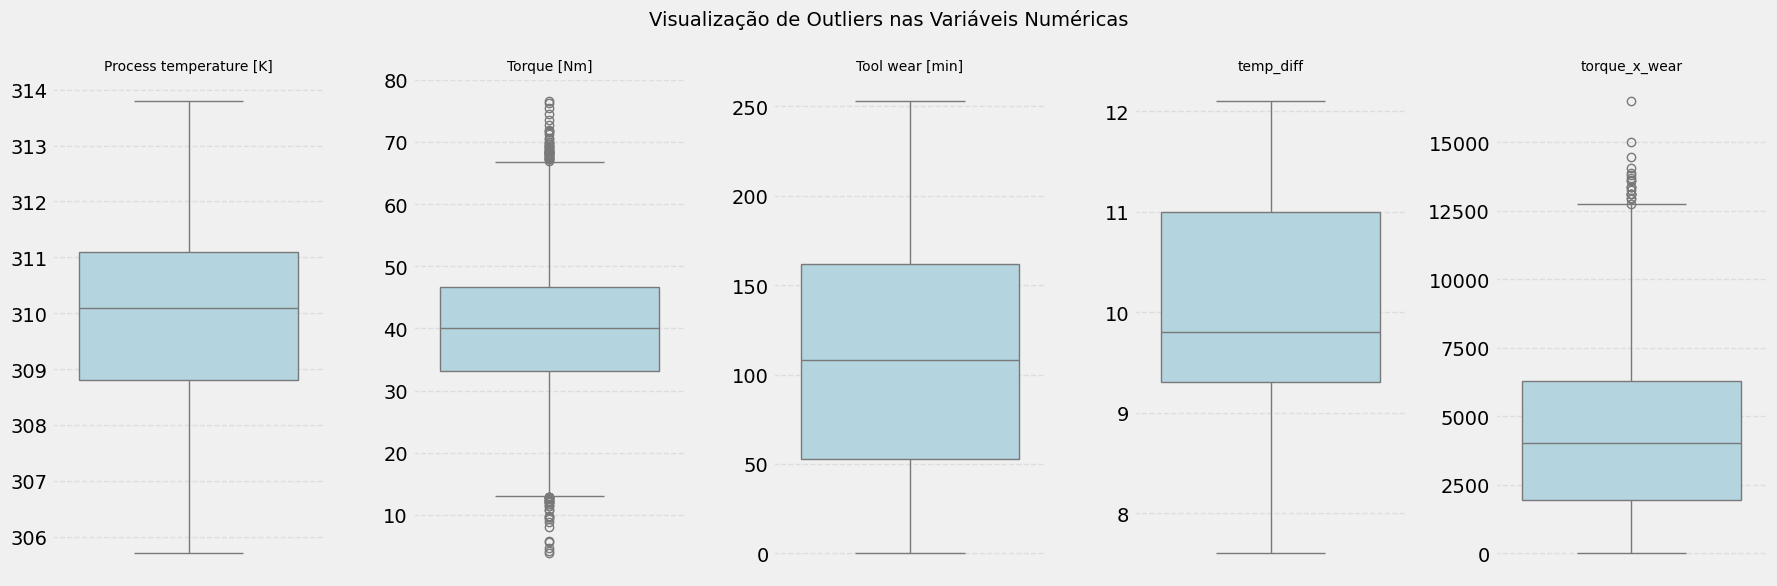

In [34]:
# Plotar os boxplots lado a lado
plt.figure(figsize=(18, 6))

for i, var in enumerate(variaveis):
    plt.subplot(1, len(variaveis), i+1)
    sns.boxplot(y=df[var], color='lightblue')
    plt.title(var, fontsize=10)
    plt.ylabel('')
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.suptitle('Visualização de Outliers nas Variáveis Numéricas', fontsize=14)
plt.tight_layout()
plt.show()

**No boxplot acima percebemos outliers nas variáveis 'Torque' e 'torque_x_wear, mas não serão removidos, pois representam comportamento operacional extremo e falhas reais e são importantes para a modelagem preditiva.**

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9991 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     9991 non-null   object 
 1   Process temperature [K]  9991 non-null   float64
 2   Torque [Nm]              9991 non-null   float64
 3   Tool wear [min]          9991 non-null   int64  
 4   Target                   9991 non-null   int64  
 5   Failure Type             9991 non-null   object 
 6   torque_x_speed           9991 non-null   float64
 7   temp_diff                9991 non-null   float64
 8   is_high_process_temp     9991 non-null   bool   
 9   torque_x_wear            9991 non-null   float64
 10  risco_esforco            9991 non-null   bool   
 11  is_critical_rpm          9991 non-null   bool   
dtypes: bool(3), float64(5), int64(2), object(2)
memory usage: 809.8+ KB


In [36]:
# Codificar a coluna 'Type' como ordinal
df['Type'] = df['Type'].map({'L': 0, 'M': 1, 'H': 2})

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9991 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     9991 non-null   int64  
 1   Process temperature [K]  9991 non-null   float64
 2   Torque [Nm]              9991 non-null   float64
 3   Tool wear [min]          9991 non-null   int64  
 4   Target                   9991 non-null   int64  
 5   Failure Type             9991 non-null   object 
 6   torque_x_speed           9991 non-null   float64
 7   temp_diff                9991 non-null   float64
 8   is_high_process_temp     9991 non-null   bool   
 9   torque_x_wear            9991 non-null   float64
 10  risco_esforco            9991 non-null   bool   
 11  is_critical_rpm          9991 non-null   bool   
dtypes: bool(3), float64(5), int64(3), object(1)
memory usage: 809.8+ KB


In [38]:
# Separar X e y para o modelo de detecção de falha (primeira etapa)
X = df.drop(columns=['Target', 'Failure Type'])  # apenas variáveis explicativas
y = df['Target']  # variável binária: falha ou não

In [39]:
# Separar treino (70%) e temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [40]:
# Separar o temporário em validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [41]:
# Confirmações
print("Shape - Treino:", X_train.shape)
print("Shape - Validação:", X_val.shape)
print("Shape - Teste:", X_test.shape)
print("\nDistribuição de falhas por conjunto:")
print("Treino:\n", y_train.value_counts(normalize=True))
print("Validação:\n", y_val.value_counts(normalize=True))
print("Teste:\n", y_test.value_counts(normalize=True))

Shape - Treino: (6993, 10)
Shape - Validação: (1499, 10)
Shape - Teste: (1499, 10)

Distribuição de falhas por conjunto:
Treino:
 Target
0    0.966967
1    0.033033
Name: proportion, dtype: float64
Validação:
 Target
0    0.966644
1    0.033356
Name: proportion, dtype: float64
Teste:
 Target
0    0.967312
1    0.032688
Name: proportion, dtype: float64


In [42]:
# Instanciar e ajustar o scaler apenas no treino
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [43]:
# Balanceado os dados de treino
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

In [44]:
X_train_bal.shape

(13524, 10)

**Para a modelagem vamos criar um modelo híbrido, que é um tipo de modelo de aprendizado em camadas, que combina as previsões de múltiplos algoritmos diferentes para formar um modelo final mais poderoso e robusto. Vamos montar nosso modelo com Random Forest e XGBoost como modelos base que seria a camada 1. Na camada 2 teremos um meta-modelo Logistic Regression que vai aprender a combinar os dois modelos base.**

**O modelo híbrido nos permite minimizar os falsos positivos e falsos negativos ao mesmo tempo, o que é essencial em manutenção preditiva.**

In [45]:
# Criação do modelo híbrido (empilhado)
rf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)
xgb = XGBClassifier(n_estimators=200, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)

stacked = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    final_estimator=lr,
    passthrough=True,
    cv=5,
    n_jobs=-1)


In [46]:
# Treinando o modelo
stacked.fit(X_train_bal, y_train_bal)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=10,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logl...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      random_state=42,
                                                      solver='liblinear'),
                   n_jobs=-1, passthrough=True)

In [47]:
y_proba_val = stacked.predict_proba(X_val_scaled)[:, 1]

precisions_val, recalls_val, thresholds_val = precision_recall_curve(y_val, y_proba_val)
f1_scores_val = 2 * (precisions_val * recalls_val) / (precisions_val + recalls_val + 1e-6)
best_idx_val = f1_scores_val.argmax()
best_threshold_val = thresholds_val[best_idx_val]

y_val_pred_adjusted = (y_proba_val > best_threshold_val).astype(int)

print("\n📊 Avaliação - Validação")
print(f"🔧 Threshold ótimo: {best_threshold_val:.2f}")
print("Precision:", precision_score(y_val, y_val_pred_adjusted))
print("Recall:", recall_score(y_val, y_val_pred_adjusted))
print("F1 Score:", f1_score(y_val, y_val_pred_adjusted))
print("ROC AUC:", roc_auc_score(y_val, y_proba_val))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_adjusted))

# ========= AVALIAÇÃO - TESTE =========
y_proba_test = stacked.predict_proba(X_test_scaled)[:, 1]

precisions_test, recalls_test, thresholds_test = precision_recall_curve(y_test, y_proba_test)
f1_scores_test = 2 * (precisions_test * recalls_test) / (precisions_test + recalls_test + 1e-6)
best_idx_test = f1_scores_test.argmax()
best_threshold_test = thresholds_test[best_idx_test]

y_test_pred_adjusted = (y_proba_test > best_threshold_test).astype(int)

print("\n📊 Avaliação - Teste")
print(f"🔧 Threshold ótimo: {best_threshold_test:.2f}")
print("Precision:", precision_score(y_test, y_test_pred_adjusted))
print("Recall:", recall_score(y_test, y_test_pred_adjusted))
print("F1 Score:", f1_score(y_test, y_test_pred_adjusted))
print("ROC AUC:", roc_auc_score(y_test, y_proba_test))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_adjusted))


📊 Avaliação - Validação
🔧 Threshold ótimo: 0.95
Precision: 0.803921568627451
Recall: 0.82
F1 Score: 0.8118811881188119
ROC AUC: 0.9931953071083506

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1449
           1       0.80      0.82      0.81        50

    accuracy                           0.99      1499
   macro avg       0.90      0.91      0.90      1499
weighted avg       0.99      0.99      0.99      1499


📊 Avaliação - Teste
🔧 Threshold ótimo: 0.97
Precision: 0.9
Recall: 0.7346938775510204
F1 Score: 0.8089887640449438
ROC AUC: 0.9502603800140745

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1450
           1       0.90      0.73      0.81        49

    accuracy                           0.99      1499
   macro avg       0.95      0.87      0.90      1499
weighted avg       0.99      0.99      0.99      1499



**Precision (Precisão):** Dos casos que o modelo disse que eram falha, 80% em validação e 90% em teste, ou seja, a cada 100 alertas, 90 estavam corretos. O modelo gerou pouquíssimos alarmes falsos, principalmente no teste. Isso é essencial em cenários industriais, onde falsas intervenções têm custo elevado.

**Recall (Sensibilidade):** Das falhas reais que existiam, o modelo encontrou 82% das falhas reais em validação e 73% das falhas reais em teste. Um modelo com bom recall evita que falhas passem despercebidas. Aqui, mesmo com um threshold conservador, o modelo conseguiu recuperar a maior parte das falhas reais, o que é vital para a confiabilidade operacional.

**F1 Score (Equilíbrio entre precision e recall):** 81% em validação e teste. O F1 score mostra que o modelo atingiu um ótimo ponto de equilíbrio. É um dos principais indicadores de qualidade em datasets desbalanceados

**ROC AUC (Área sob a curva ROC):** Capacidade geral do modelo de separar as classes em diferentes limiares encontramos 0.99 em validação e 0.95 em teste. Resultados acima de 0.90 indicam um classificador extremamente confiável e com forte poder discriminativo.

**Accuracy (Acurácia):** 99% em validaão e teste, mas temos que ter atenção, pois problemas desbalanceados como este, a accuracy pode enganar pois o modelo pode acertar quase tudo dizendo só "não falha". Por isso é importante analisar outras métricas.

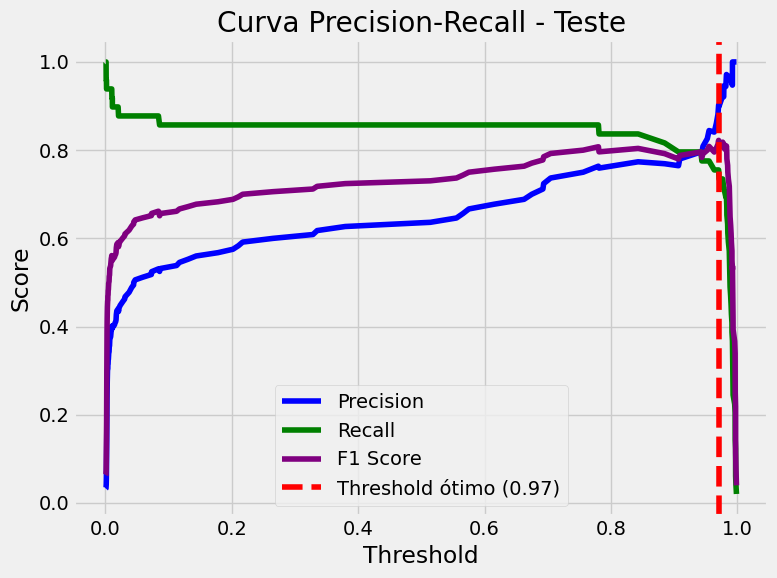

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds_test, precisions_test[:-1], label='Precision', color='blue')
plt.plot(thresholds_test, recalls_test[:-1], label='Recall', color='green')
plt.plot(thresholds_test, f1_scores_test[:-1], label='F1 Score', color='purple')
plt.axvline(x=best_threshold_test, color='red', linestyle='--', label=f'Threshold ótimo ({best_threshold_test:.2f})')
plt.title('Curva Precision-Recall - Teste')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**O gráfico acima confirma as métricas:**

**Precision:** Aumenta conforme o modelo se torna mais conservador (threshold).

**Recall:** Cai com thresholds altos (menos falhas detectadas).

**F1 Score:** Ponto ótimo de equilíbrio entre precisão e recall.

**O modelo está bem ajustado entre segurança operacional e confiabilidade de alerta, exatamente o que se espera em ambientes industriais reais de manutenção preditiva.**

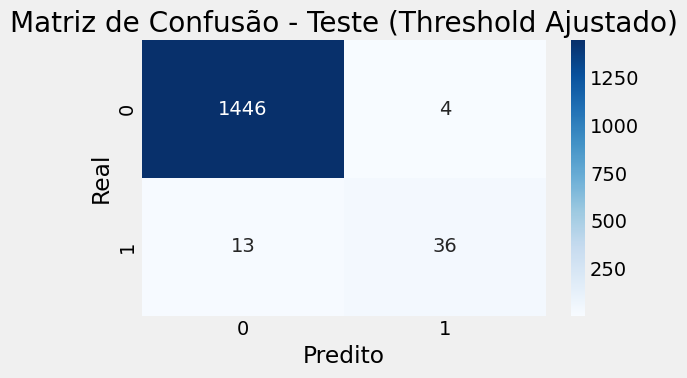

In [49]:
# Observando a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred_adjusted), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Teste (Threshold Ajustado)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

**Na matriz de confusão acima percebemos que o modelo reconhece 1446 dos casos sem falha são verdadeiros negativos. Temos 36 verdadeiros positivos, ou seja, o modelo está captando as falhas com ótima sensibilidade. Temos 4 falsos positivos, onde teve alerta de falha onde não havia, extremamente baixo e isso evita alarmes desnecessários. E por fim temos 13 falsos negativos, o que é um valor razoável dado que a precisão está em 90% e o recall em 73%.**

**Agora vamos iniciar o desenvolvimento do segundo modelo que tem como objetivo prever o tipo de falha apresentada pela máquina, condicionado à existência de uma falha já detectada (conforme identificado no Modelo 1). Para essa tarefa de classificação multiclasse, foi adotada uma abordagem com Stacking Classifier, combinando Random Forest, XGBoost e Regressão Logística multinomial como meta-modelo.**

In [50]:
# Carregando novamente o dataset original
df = pd.read_csv('/content/predictive_maintenance.csv')

In [51]:
# Filtrando apenas os casos com falhas
df_multi = df[df['Target'] == 1].copy()

In [52]:
# Deletando a classe equivocada No Failure nas falhas
df_multi = df_multi[~((df_multi['Target'] == 1) & (df_multi['Failure Type'] == 'No Failure'))]

In [53]:
# Recriando as features
df_multi['Type'] = df_multi['Type'].map({'L': 0, 'M': 1, 'H': 2})
df_multi['torque_x_speed'] = df_multi['Torque [Nm]'] * df_multi['Rotational speed [rpm]']
df_multi['temp_diff'] = df_multi['Process temperature [K]'] - df_multi['Air temperature [K]']
df_multi['is_high_process_temp'] = (df_multi['Process temperature [K]'] > 310.5).astype(int)
df_multi['torque_x_wear'] = df_multi['Torque [Nm]'] * df_multi['Tool wear [min]']
df_multi['risco_esforco'] = ((df_multi['Torque [Nm]'] > 55) & (df_multi['Tool wear [min]'] > 180)).astype(int)
df_multi['is_critical_rpm'] = df_multi['Rotational speed [rpm]'].between(1400, 1500).astype(int)

In [54]:
# Removendo as colunas que não serão úteis para o modelo
df_multi.drop(columns=['UDI', 'Product ID','Air temperature [K]', 'Rotational speed [rpm]', 'Target'], inplace=True)

In [55]:
# Separarando X e y
X_multi = df_multi.drop(columns=['Failure Type'])
y_multi = df_multi['Failure Type']

In [56]:
# Dividindo em treino, validação e teste
X_train_multi, X_temp_multi, y_train_multi, y_temp_multi = train_test_split(X_multi, y_multi, test_size=0.3, stratify=y_multi, random_state=42)
X_val_multi, X_test_multi, y_val_multi, y_test_multi = train_test_split(X_temp_multi, y_temp_multi, test_size=0.5, stratify=y_temp_multi, random_state=42)

In [57]:
# Padronizando
scaler_multi = StandardScaler()
X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi)
X_val_multi_scaled = scaler_multi.transform(X_val_multi)
X_test_multi_scaled = scaler_multi.transform(X_test_multi)

In [58]:
# Balanceado
smote_multi = SMOTE(random_state=42)
X_train_multi_bal, y_train_multi_bal = smote_multi.fit_resample(X_train_multi_scaled, y_train_multi)

In [59]:
# Criando o modelo base e o meta-modelo
rf_multi = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)
xgb_multi = XGBClassifier(n_estimators=200, max_depth=5, use_label_encoder=False, eval_metric='mlogloss', objective='multi:softprob', num_class=5, random_state=42)
lr_multi = LogisticRegression(class_weight='balanced', solver='saga', multi_class='multinomial', max_iter=5000, random_state=42)

stacked_multi = StackingClassifier(
    estimators=[('rf', rf_multi), ('xgb', xgb_multi)],
    final_estimator=lr_multi,
    cv=5,
    n_jobs=-1)


In [60]:
# Treinando
stacked_multi.fit(X_train_multi_bal, y_train_multi_bal)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=10,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlog...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_class=5,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=5000,
                                                      multi_class='multinomial',
                                                      random_state=42,
                                                      solver='saga'),
                   n_jobs=-1)

In [61]:
# Avaliação - Validação
y_val_multi_pred = stacked_multi.predict(X_val_multi_scaled)
y_val_multi_proba = stacked_multi.predict_proba(X_val_multi_scaled)

print("\n📊 Avaliação - Validação (Modelo 2)")
print("Accuracy:", accuracy_score(y_val_multi, y_val_multi_pred))
print("Precision (macro):", precision_score(y_val_multi, y_val_multi_pred, average='macro'))
print("Recall (macro):", recall_score(y_val_multi, y_val_multi_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_val_multi, y_val_multi_pred, average='macro'))
print("ROC AUC (macro):", roc_auc_score(y_val_multi, y_val_multi_proba, multi_class='ovr', average='macro'))
print("\nClassification Report:\n", classification_report(y_val_multi, y_val_multi_pred))

# Avaliação - Teste
y_test_multi_pred = stacked_multi.predict(X_test_multi_scaled)
y_test_multi_proba = stacked_multi.predict_proba(X_test_multi_scaled)

print("\n📊 Avaliação - Teste (Modelo 2)")
print("Accuracy:", accuracy_score(y_test_multi, y_test_multi_pred))
print("Precision (macro):", precision_score(y_test_multi, y_test_multi_pred, average='macro'))
print("Recall (macro):", recall_score(y_test_multi, y_test_multi_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test_multi, y_test_multi_pred, average='macro'))
print("ROC AUC (macro):", roc_auc_score(y_test_multi, y_test_multi_proba, multi_class='ovr', average='macro'))
print("\nClassification Report:\n", classification_report(y_test_multi, y_test_multi_pred))


📊 Avaliação - Validação (Modelo 2)
Accuracy: 0.9795918367346939
Precision (macro): 0.9861111111111112
Recall (macro): 0.9642857142857143
F1 Score (macro): 0.9736263736263737
ROC AUC (macro): 1.0

Classification Report:
                           precision    recall  f1-score   support

Heat Dissipation Failure       0.94      1.00      0.97        17
      Overstrain Failure       1.00      1.00      1.00        11
           Power Failure       1.00      1.00      1.00        14
       Tool Wear Failure       1.00      0.86      0.92         7

                accuracy                           0.98        49
               macro avg       0.99      0.96      0.97        49
            weighted avg       0.98      0.98      0.98        49


📊 Avaliação - Teste (Modelo 2)
Accuracy: 0.9
Precision (macro): 0.8801659125188537
Recall (macro): 0.8573179271708684
F1 Score (macro): 0.8633400946585531
ROC AUC (macro): 0.988507491290719

Classification Report:
                           precis

**O modelo apresenta excelente desempenho na validação, com altíssimo equilíbrio entre as classes. As métricas de precisão, recall e F1-score mantêm-se elevadas para todas as categorias, mesmo para aquelas com menor representatividade, como Tool Wear Failure.**

**Em teste o modelo manteve excelente desempenho, indicando boa generalização. Observa-se desempenho consistente em quase todas as classes, com leve redução no recall da classe Tool Wear Failure, o que é aceitável, dado o número reduzido de amostras dessa categoria no teste.**

**Os resultados confirmam que o modelo é altamente eficaz para classificar os diferentes tipos de falha mecânica, com forte capacidade de generalização e estabilidade estatística. A estrutura de empilhamento utilizada contribuiu significativamente para a performance robusta, mesmo diante de classes com baixo suporte amostral.**

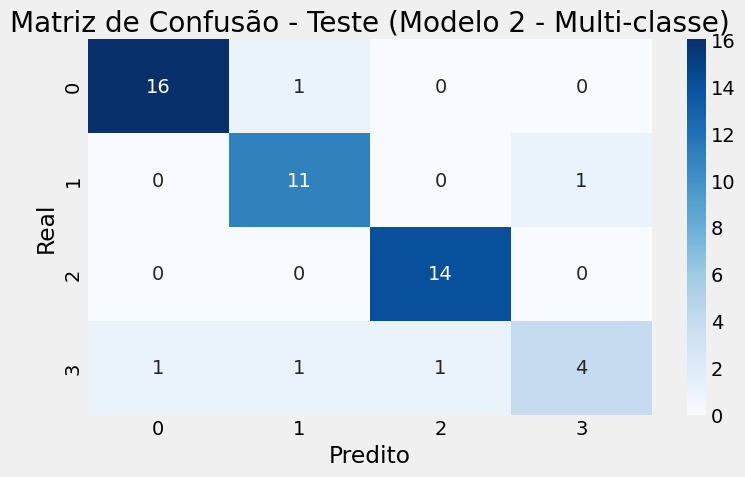

In [62]:
# Matriz de Confusão - Teste
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test_multi, y_test_multi_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Teste (Modelo 2 - Multi-classe)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

**A matriz acima confirma que o modelo está extremamente confiável nas classes principais.**

**0 (Heat Dissipation Failure):** Acertou 16 falhas e errou apenas 1.

**1 (Overstrain Failure):** Acertou 11 falhas e errou 1 também.

**2 (Power Failure):** Acertou todas as 14 falhas.

**3 (Tool Wear Failure):** Acertou 4 falhas e errou 3, muito se deve pelos poucos registros da classe.

**O modelo apresenta excelente desempenho na validação, com altíssimo equilíbrio entre as classes. As métricas de precisão, recall e F1-score mantêm-se elevadas para todas as categorias, mesmo para aquelas com menor representatividade, como Tool Wear Failure.**

**Em teste o modelo manteve excelente desempenho, indicando boa generalização. Observa-se desempenho consistente em quase todas as classes, com leve redução no recall da classe Tool Wear Failure, o que é aceitável, dado o número reduzido de amostras dessa categoria no teste.**

**Os resultados confirmam que o modelo é altamente eficaz para classificar os diferentes tipos de falha mecânica, com forte capacidade de generalização e estabilidade estatística. A estrutura de empilhamento utilizada contribuiu significativamente para a performance robusta, mesmo diante de classes com baixo suporte amostral.**

**Agora vamos observar as informações previstas pelos 2 modelos. O modelo binário que detecta se existe ou não falha e o modelo multi-classe que classifica qual o tipo de falha, se houver. O código vai diagnosticar automaticamente o estado de funcionamento das máquinas.**

In [63]:
# Função de diagnóstico para uma única máquina
def diagnosticar_maquina(dados_linha, scaler_bin, modelo_bin, scaler_multi, modelo_multi, features_bin, features_multi, limiar_bin=0.97):
    dados_df = pd.DataFrame([dados_linha])
    X_bin = scaler_bin.transform(dados_df[features_bin])
    proba_falha = modelo_bin.predict_proba(X_bin)[0][1] # Aplica o modelo binário
    falha_detectada = int(proba_falha > limiar_bin)
    # Se ultrapassar o limiar de 97%, existe a falha e o modelo multi-classe é aplicado
    if falha_detectada:
        X_multi = scaler_multi.transform(dados_df[features_multi])
        tipo_falha = modelo_multi.predict(X_multi)[0]
    else:
        tipo_falha = None

    return {
        'Falha detectada': bool(falha_detectada),
        'Probabilidade de falha': round(proba_falha, 3),
        'Tipo de falha': tipo_falha,
        'Tipo de máquina': dados_linha.get('Type', 'Desconhecido')
    }

# Função para diagnosticar várias máquinas e exibir resultados
def diagnosticar_varias_maquinas(df_amostras, scaler_bin, modelo_bin, scaler_multi, modelo_multi,
                                  features_bin, features_multi, limiar_bin=0.97):
    resultados = []
    for _, linha in df_amostras.iterrows():
        dados_linha = linha.to_dict()
        diag = diagnosticar_maquina(dados_linha, scaler_bin, modelo_bin, scaler_multi, modelo_multi,
                                    features_bin, features_multi, limiar_bin)
        resultados.append(diag)

        tipo_maquina_legivel = {0: 'L', 1: 'M', 2: 'H'}.get(diag['Tipo de máquina'], diag['Tipo de máquina'])
        status = "FALHA" if diag['Falha detectada'] else "Normal"
        cor_status = 'red' if diag['Falha detectada'] else 'green'

        # Exibição formatada com HTML

        html = f"""
        <div style="border:1px solid #ccc; border-radius:8px; padding:10px; margin:10px 0;">
            <b style="color:#003366;">🛠 Diagnóstico:</b><br>
            <b style="color:#003366;">Tipo de máquina:</b> {tipo_maquina_legivel}<br>
            <b style="color:#003366;">Probabilidade de falha:</b> {diag['Probabilidade de falha']}<br>
           <b style="color:{cor_status};">Status:</b> {status}<br>
        """
        if diag['Falha detectada']:
            html += f"""<b style="color:magenta;">Tipo de falha:</b> {diag['Tipo de falha']}<br>"""

        html += "</div>"
        display(HTML(html))

    return pd.DataFrame(resultados)



# Exibição do diagnóstico
scaler_bin = scaler
features_bin = X_train.columns.tolist()
features_multi = X_train_multi.columns.tolist()

# Exemplo de uso
# Certificando que a coluna 'Type' está presente
X_test_copy = X_test.copy()
X_test_copy['Type'] = df.loc[X_test.index, 'Type'].map({'L': 0, 'M': 1, 'H': 2})

# Redefinindo features com segurança
features_bin = list(X_train.columns)
features_multi = list(X_train_multi.columns)

# Executar diagnóstico
df_resultados = diagnosticar_varias_maquinas(
    X_test_copy,
    scaler_bin, stacked,
    scaler_multi, stacked_multi,
    features_bin, features_multi,
    limiar_bin=0.97
)
df_resultados['Tipo de máquina'] = df_resultados['Tipo de máquina'].map({0: 'L', 1: 'M', 2: 'H'})

df_resultados.head()


,Falha detectada,Probabilidade de falha,Tipo de falha,Tipo de máquina
0,False,0.002,None,L
1,False,0.002,None,L
2,False,0.002,None,L
3,False,0.001,None,M
4,False,0.002,None,L


In [64]:
# Preenchendo a parte em branco por Funcionamento Normal para o dashborad
df_resultados['Tipo de falha'] = df_resultados['Tipo de falha'].fillna('Funcionamento Normal')

In [65]:
df_resultados

,Falha detectada,Probabilidade de falha,Tipo de falha,Tipo de máquina
0,False,0.002,Funcionamento Normal,L
1,False,0.002,Funcionamento Normal,L
2,False,0.002,Funcionamento Normal,L
3,False,0.001,Funcionamento Normal,M
4,False,0.002,Funcionamento Normal,L
...,...,...,...,...
1494,False,0.002,Funcionamento Normal,L
1495,False,0.059,Funcionamento Normal,M
1496,False,0.001,Funcionamento Normal,M
1497,False,0.002,Funcionamento Normal,L


In [66]:
# Salvado os resultados em csv
df_resultados.to_csv('diagnostico_maquinas.csv', index=False)

**Vamos criar um dashboard interativo com os resultados finais.**

In [67]:
# Carregando os dados finais
df_resultados = pd.read_csv('/content/diagnostico_maquinas.csv')

In [68]:
# Dashboard interativo com Dash

app = dash.Dash(__name__)
app.title = "Dashboard de Diagnóstico de Máquinas"

# Layout
app.layout = html.Div([
    html.H1("⚙️ Diagnóstico de Máquinas", style={'textAlign': 'center'}),

    html.Div([
        html.Div([
            html.H4("Total de Máquinas"),
            html.H2(f"{len(df_resultados)}"),
        ], className='card'),

        html.Div([
            html.H4("Falhas Detectadas"),
            html.H2(f"{df_resultados['Falha detectada'].sum()}"),
        ], className='card'),

        html.Div([
            html.H4("Sem Falhas"),
            html.H2(f"{(~df_resultados['Falha detectada']).sum()}"),
        ], className='card'),
    ], className='card-container'),

    html.Div([
        dcc.Graph(
            figure=px.pie(df_resultados, names='Tipo de máquina', title='Distribuição por Tipo de Máquina')
        )
    ]),

    html.Div([
        dcc.Graph(
            figure=px.histogram(df_resultados[df_resultados['Falha detectada']], x='Tipo de falha', color='Tipo de máquina',
                                 title='Tipos de Falhas Detectadas', barmode='group')
        )
    ]),

    html.Div([
        html.H3("Tabela de Diagnóstico"),
        dash_table.DataTable(
            columns=[{"name": i, "id": i} for i in df_resultados.columns],
            data=df_resultados.to_dict('records'),
            style_table={'overflowX': 'auto'},
            style_cell={
                'textAlign': 'center',
                'padding': '5px'
            },
            style_header={
                'backgroundColor': 'lightgrey',
                'fontWeight': 'bold'
            },
            style_data_conditional=[
                {
                    'if': {
                        'filter_query': '{Falha detectada} = True',
                        'column_id': 'Falha detectada'
                    },
                    'backgroundColor': '#ffcccc',
                    'color': 'red',
                    'fontWeight': 'bold'
                }
            ]
        )
    ])
], style={'padding': '20px'})

# Estilos CSS
app.index_string = '''
<!DOCTYPE html>
<html>
    <head>
        {%metas%}
        <title>{%title%}</title>
        {%favicon%}
        {%css%}
        <style>
            body {font-family: "Arial", sans-serif; background-color: #f5f5f5;}
            .card-container {display: flex; justify-content: space-around; margin-bottom: 30px;}
            .card {background: white; padding: 20px; border-radius: 10px; box-shadow: 2px 2px 10px rgba(0,0,0,0.1); text-align: center; width: 30%;}
        </style>
    </head>
    <body>
        {%app_entry%}
        <footer>
            {%config%}
            {%scripts%}
            {%renderer%}
        </footer>
    </body>
</html>
'''

# Roda o app
if __name__ == '__main__':
    app.run(debug=False, port=8050)


<IPython.core.display.Javascript object>